<a href="https://colab.research.google.com/github/3lochana/20331A05C3/blob/main/Human_Action_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

!pip install pafy youtube-dl moviepy


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 10.1 MB/s eta 0:00:00


In [ ]:

import os
import cv2
import pafy
import math
import random
import numpy as np
import datetime as dt
import tensorflow as tf
from collections import deque
import matplotlib.pyplot as plt



In [ ]:
from moviepy.editor import *
%matplotlib inline

In [ ]:
from sklearn.model_selection import train_test_split


In [ ]:
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

set Numpy,Pyhton,and  tensorflow seeds to get consistent results on every execution

In [ ]:
seed_constant = 27
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

**Download and visualize the data with its labels**

In [ ]:
#%%capture
#Downloading the UCF50 Dataset
!wget --no-check-certificate https://www.crcv.ucf.edu/data/UCF50.rar
#Extract the Dataset
!unrar x UCF50.rar

Streaming output truncated to the last 5000 lines.
Extracting  UCF50/HorseRace/v_HorseRace_g16_c03.avi                       23%  OK 
Extracting  UCF50/HorseRace/v_HorseRace_g16_c04.avi                       23%  OK 
Extracting  UCF50/HorseRace/v_HorseRace_g16_c05.avi                       23%  OK 
Extracting  UCF50/HorseRace/v_HorseRace_g17_c01.avi                       23%  OK 
Extracting  UCF50/HorseRace/v_HorseRace_g17_c02.avi                       23%  OK 
Extracting  UCF50/HorseRace/v_HorseRace_g17_c03.avi                       23%  OK 
Extracting  UCF50/HorseRace/v_HorseRace_g17_c04.avi                       23%  OK 
Extracting  UCF50/HorseRace/v_HorseRace_g17_c05.avi                       23%  OK 
Extracting  UCF50/HorseRace/v_HorseRace_g18_c01.avi                       23%  OK 
Extracting  UCF50/HorseRace/v_HorseRace_g18_c02.avi                       23%  OK 
Extracting  UCF50/HorseRace/v

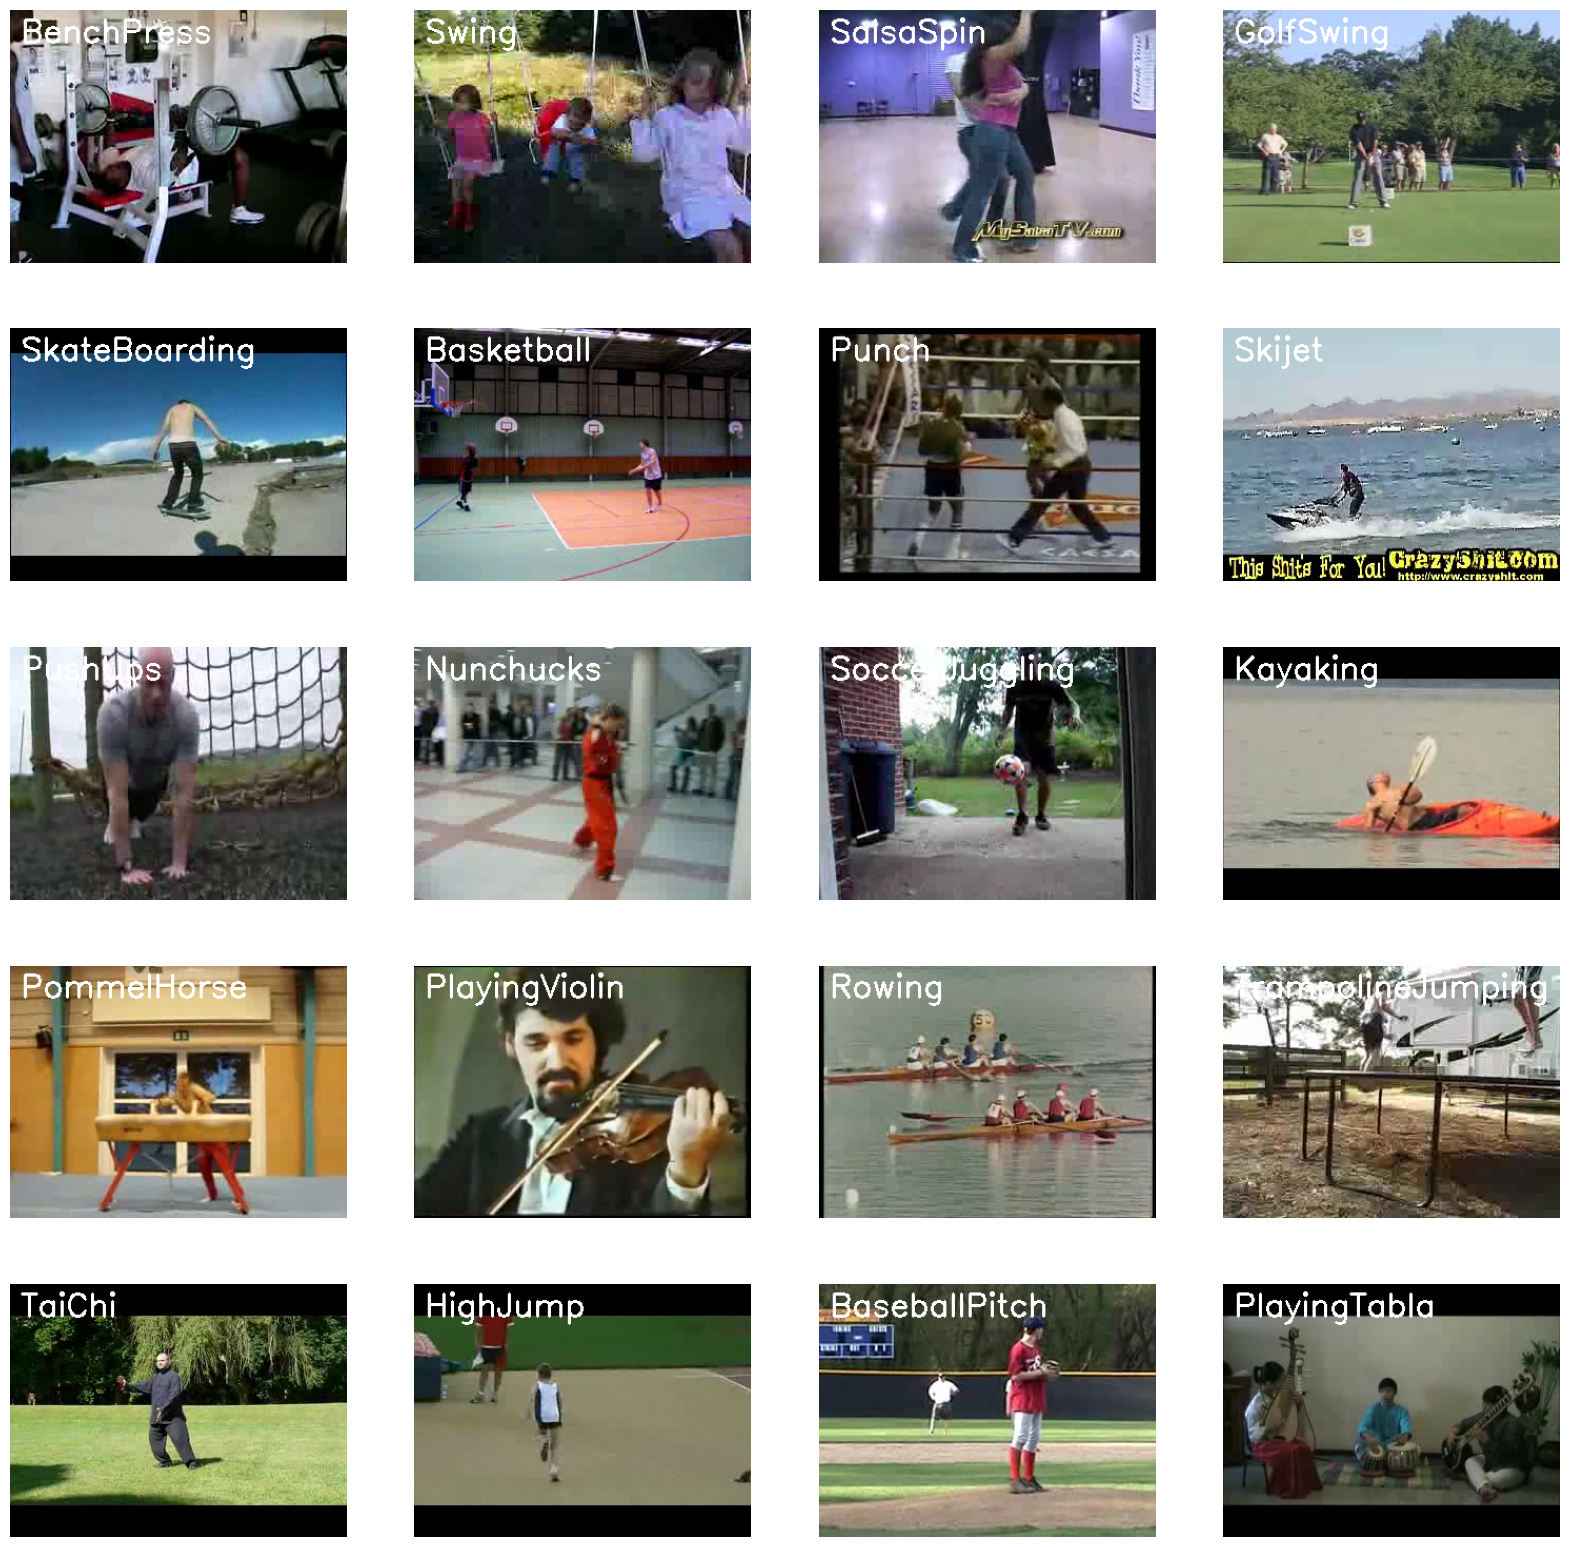

In [ ]:
#create a matplotlib figure and specify the size of the figure
plt.figure(figsize=(20,20))

#Get the names of all classes/categories in UCF50.
all_classes_names = os.listdir('UCF50')
#where 50 is the total number of class in the dataset
random_range = random.sample(range(len(all_classes_names)),20)

#iterate through all the generated random values
for counter,random_index in enumerate(random_range,1):
  #retrieve a class name using random index
  selected_class_Name=all_classes_names[random_index]
  #retrive the list of all the video files present in the randomly selectedclass directory
  video_files_names_list=os.listdir(f'UCF50/{selected_class_Name}')
  selected_video_file_name = random.choice(video_files_names_list)
  video_reader = cv2.VideoCapture(f'UCF50/{selected_class_Name}/{selected_video_file_name}')
  _, bgr_frame = video_reader.read()
  video_reader.release()
  rgb_frame = cv2.cvtColor(bgr_frame,cv2.COLOR_BGR2RGB)
  cv2.putText(rgb_frame, selected_class_Name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
  plt.subplot(5,4,counter);plt.imshow(rgb_frame);plt.axis('off')





# **Preprocess the Dataset**

In [ ]:
#specify the height and width to which each video frame will be realized in our dataset
IMAGE_HEIGHT,IMAGE_WIDTH=64,64
#specify the number of frames of a video that will be fed to the model as one sequence
SEQUENCE_LENGTH=20
#specify the directory containing the dataset
DATASET_DIR="UCF50"

#specify the list containing the names of the classes used for training .
CLASSES_LIST=["WalkingWithDog","TaiChi","Swing","HorseRace"]



### **Create a function to extact ,resize and normalize frames**

we will create a function frames_extraction() that will create list
### containing the resized and normalized frames of a video whose path is passed to it as an argument.The function will read the video file frame by frame ,although not all frames are added to the list as we will only need an evenly distributed sequence length of frames


In [ ]:
def frames_extraction(video_path):
  #declare a list to store video frame
  frames_list=[]

  #read the video file using the videocapture object
  video_reader=cv2.VideoCapture(video_path)
  #get the total number of frames in the video
  video_frames_count=int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
  #calculate the interval after which frames will be added to the list
  skip_frames_window=max(int(video_frames_count/SEQUENCE_LENGTH),1)

  #Iterate through the Video Frames
  for frame_counter in range(SEQUENCE_LENGTH):
    #set the current frame position of the video
    video_reader.set(cv2.CAP_PROP_POS_FRAMES,frame_counter * skip_frames_window)

    #reading the frame from the video
    success,frame=video_reader.read()

    #check if video frame is not successfully read then break in the loop
    if not success:
      break
    #resize the frame to find height and width

    resized_frame=cv2.resize(frame,(IMAGE_HEIGHT,IMAGE_WIDTH))
     #Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1
    normalized_frame = resized_frame / 255
      #append the normalized frame into the frames list
    frames_list.append(normalized_frame)

      #Realise the VideoCapture object
  video_reader.release()
      #return the frames_list
  return frames_list





In [ ]:
import os
from os import listdir
import numpy as np

In [ ]:
def create_dataset():
    # declared empty lists to store the features, labels, and video file path values
    features = []
    labels = []
    video_files_paths = []

    # Iterating through all the classes mentioned in the classes list
    for class_index, class_name in enumerate(CLASSES_LIST):
        # display the name of the class whose data is being extracted
        print(f'Extracting Data of Class: {class_name}')

        # Get the list of video files present in the specific class name directory.
        files_list = listdir(os.path.join(DATASET_DIR, class_name))

        # Iterate through all the files present in the files list.
        for file_name in files_list:
            # Get the complete video path.
            video_file_path = os.path.join(DATASET_DIR, class_name, file_name)

            # Extract the frames of the video file.
            frames = frames_extraction(video_file_path)

            # Check if the extracted frames are equal to the SEQUENCE LENGTH specified above. Ignore videos having frames less than the SEQUENCE LENGTH.
            if len(frames) == SEQUENCE_LENGTH:
                # Append the data to their respective lists.
                features.append(frames)
                labels.append(class_index)
                video_files_paths.append(video_file_path)

    # Converting the list to NumPy arrays
    features = np.asarray(features)
    labels = np.array(labels)

    # Return the frames, class Index, and video file path.
    return features, labels, video_files_paths



now we will utilize the function create_dataset() created above to extract the data of the selected classes and create the required dataset

In [ ]:
# create the dataset
features,labels,video_files_paths = create_dataset()


Extracting Data of Class: WalkingWithDog
Extracting Data of Class: TaiChi
Extracting Data of Class: Swing
Extracting Data of Class: HorseRace


In [ ]:
# Using Keras's to_categorical method to convert labels into one-hot-encoded vectors
one_hot_encoded_labels = to_categorical(labels)

**Split tha data into Train and Test Set**

In [ ]:
features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels,test_size = 0.25, shuffle = True, random_state = seed_constant)



**Implement the LRCN Approach**

### construct the model

In [ ]:
def create_LRCN_model():
    '''
    This function will construct the required LRCN model.
    Returns:
        model: It is the required constructed LRCN model.
    '''

    # We will use a Sequential model for model construction.
    model = Sequential()

    # Define the Model Architecture.
    ########################################################################################################################

    model.add(TimeDistributed(Conv2D(16, (3, 3), padding='same',activation = 'relu'),
                              input_shape = (SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3)))

    model.add(TimeDistributed(MaxPooling2D((4, 4))))
    model.add(TimeDistributed(Dropout(0.25)))

    model.add(TimeDistributed(Conv2D(32, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((4, 4))))
    model.add(TimeDistributed(Dropout(0.25)))

    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Dropout(0.25)))

    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    #model.add(TimeDistributed(Dropout(0.25)))

    model.add(TimeDistributed(Flatten()))

    model.add(LSTM(32))

    model.add(Dense(len(CLASSES_LIST), activation = 'softmax'))

    ########################################################################################################################

    # Display the models summary.
    model.summary()

    # Return the constructed LRCN model.
    return model

In [ ]:
# Construct the required LRCN model.
LRCN_model = create_LRCN_model()

# Display the success message.
print("Model Created Successfully!")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 20, 64, 64, 16)   448       
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 20, 16, 16, 16)   0         
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 20, 16, 16, 16)   0         
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 20, 16, 16, 32)   4640      
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 20, 4, 4, 32)     0

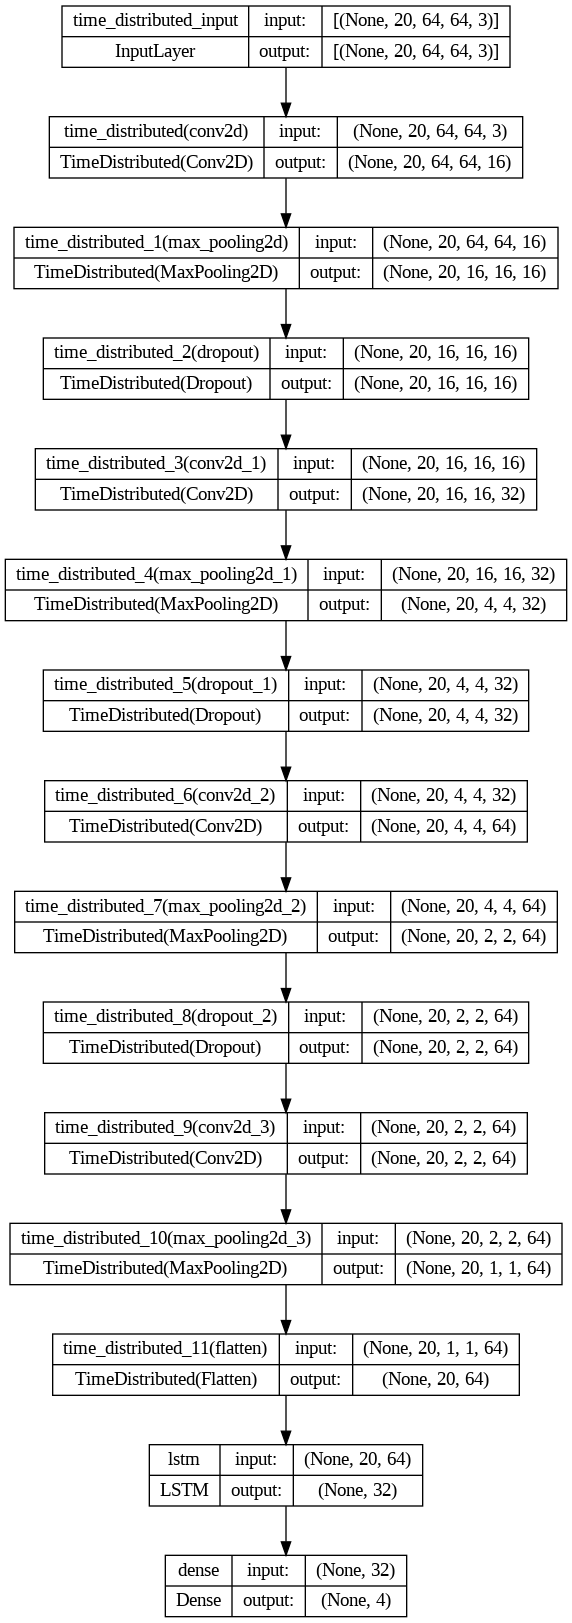

In [ ]:
plot_model(LRCN_model, to_file = 'LRCN_model_structure_plot.png', show_shapes = True, show_layer_names = True)

Compile & Train the Model

In [ ]:
# Create an Instance of Early Stopping Callback.
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 15, mode = 'min', restore_best_weights = True)

# Compile the model and specify loss function, optimizer and metrics to the model.
LRCN_model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])

# Start training the model.
LRCN_model_training_history = LRCN_model.fit(x = features_train, y = labels_train, epochs = 70, batch_size = 4 ,
                                             shuffle = True, validation_split = 0.2, callbacks = [early_stopping_callback])

Epoch 1/70
73/73 [==============================] - 23s 263ms/step - loss: 1.3856 - accuracy: 0.2397 - val_loss: 1.3329 - val_accuracy: 0.3836
Epoch 2/70
73/73 [==============================] - 16s 226ms/step - loss: 1.3072 - accuracy: 0.4041 - val_loss: 1.5493 - val_accuracy: 0.1918
Epoch 3/70
73/73 [==============================] - 17s 228ms/step - loss: 1.2182 - accuracy: 0.4658 - val_loss: 1.3160 - val_accuracy: 0.4384
Epoch 4/70
73/73 [==============================] - 18s 247ms/step - loss: 1.0733 - accuracy: 0.5377 - val_loss: 1.0399 - val_accuracy: 0.6301
Epoch 5/70
73/73 [==============================] - 16s 222ms/step - loss: 0.8401 - accuracy: 0.6541 - val_loss: 0.8694 - val_accuracy: 0.6575
Epoch 6/70
73/73 [==============================] - 16s 223ms/step - loss: 0.9691 - accuracy: 0.5788 - val_loss: 1.1537 - val_accuracy: 0.4795
Epoch 7/70
73/73 [==============================] - 17s 239ms/step - loss: 0.7624 - accuracy: 0.7089 - val_loss: 0.9196 - val_accuracy: 0.6986

## Evaluating the trained model

In [ ]:
# Evaluate the trained model.
model_evaluation_history = LRCN_model.evaluate(features_test, labels_test)

4/4 [==============================] - 3s 554ms/step - loss: 0.3526 - accuracy: 0.8934


## Save the model

In [ ]:
# Get the loss and accuracy from model_evaluation_history.
model_evaluation_loss, model_evaluation_accuracy = model_evaluation_history

# Define the string date format.
# Get the current Date and Time in a DateTime Object.
# Convert the DateTime object to string according to the style mentioned in date_time_format string.
date_time_format = '%Y_%m_%d__%H_%M_%S'
current_date_time_dt = dt.datetime.now()
current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format)

# Define a useful name for our model to make it easy for us while navigating through multiple saved models.
model_file_name = f'LRCN_model___Date_Time_{current_date_time_string}___Loss_{model_evaluation_loss}___Accuracy_{model_evaluation_accuracy}.h5'

# Save the Model.
LRCN_model.save(model_file_name)

### Plot Models Loss and Accuracy Curves

In [ ]:
def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name):
    '''
    This function will plot the metrics passed to it in a graph.
    Args:
        model_training_history: A history object containing a record of training and validation
                                loss values and metrics values at successive epochs
        metric_name_1:          The name of the first metric that needs to be plotted in the graph.
        metric_name_2:          The name of the second metric that needs to be plotted in the graph.
        plot_name:              The title of the graph.
    '''

    # Get metric values using metric names as identifiers.
    metric_value_1 = model_training_history.history[metric_name_1]
    metric_value_2 = model_training_history.history[metric_name_2]

    # Construct a range object which will be used as x-axis (horizontal plane) of the graph.
    epochs = range(len(metric_value_1))

    # Plot the Graph.
    plt.plot(epochs, metric_value_1, 'blue', label = metric_name_1)
    plt.plot(epochs, metric_value_2, 'red', label = metric_name_2)

    # Add title to the plot.
    plt.title(str(plot_name))

    # Add legend to the plot.
    plt.legend()

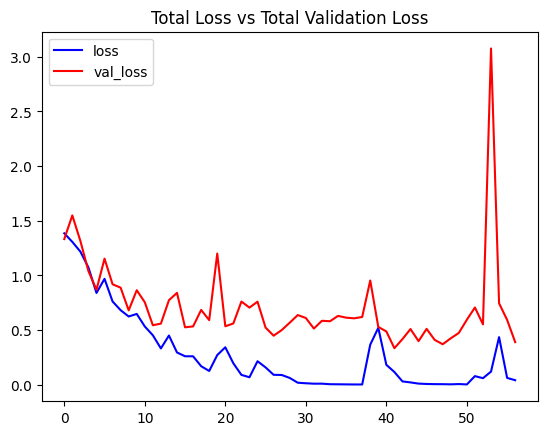

In [ ]:
# Visualize the training and validation loss metrices.
plot_metric(LRCN_model_training_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

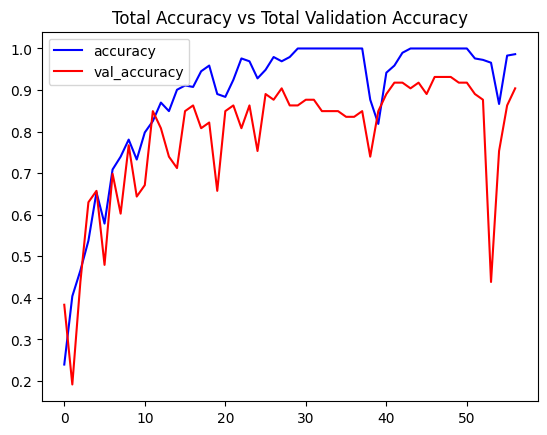

In [ ]:
# Visualize the training and validation accuracy metrices.
plot_metric(LRCN_model_training_history, 'accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy')